In [99]:
# Âá∫Ëµ∞È¶¨„Å´„Å§„ÅÑ„Å¶‰∏ä‰Ωç„Å´ÂÖ•„ÇãÁ¢∫Áéá„Çí‰∫àÊÉ≥„Åó„ÄÅÁ¢∫Áéá„ÅåÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„Å´Èôê„ÇäË≥ºÂÖ•„Åô„Çã„Åì„Å®„ÇíËÄÉ„Åà„Çã
# ÈñæÂÄ§„Çí‰Ωø„Çè„Åö„Å´Ë≥ºÂÖ•„Åó„ÅüÂ†¥Âêà„Å®ÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÅßÊØîËºÉ„Åó„ÄÅÁöÑ‰∏≠Áéá„ÇÑÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã

In [1]:
# „Ç§„É≥„Éù„Éº„Éà
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [35]:
# CSV„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
df = pd.read_csv('input_Á∑®ÈõÜÂæå.csv', encoding='utf-8')
print(f"df„ÅÆË°åÊï∞„ÅØ {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # Êó•‰ªò„ÅåÊñáÂ≠óÂàó„Å™„ÇâÂ§âÊèõ
# ===== Âπ¥Â∫¶Ë®≠ÂÆöÔºà„Åì„Åì„ÇíÂ§â„Åà„Çå„Å∞‰ªñ„ÅÆÂπ¥Â∫¶„Åß„ÇÇÂØæÂøúÂèØËÉΩÔºâ =====
train_year = 2023
valid_year = 2024
# „Éï„Ç£„É´„ÇøÊù°‰ª∂„ÇíÈÅ©Áî®
filtered_df = df[
    (df['race_date'].dt.year >= train_year) &
    (df['race_date'].dt.year <= valid_year)
]
print(f"filtered_df„ÅÆË°åÊï∞„ÅØ {len(filtered_df)} ")
# „É¨„Éº„ÇπID„ÄÅÈ¶¨Áï™È†Ü„Å´‰∏¶„Å≥Êõø„Åà
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])

df„ÅÆË°åÊï∞„ÅØ 51816 
filtered_df„ÅÆË°åÊï∞„ÅØ 22088 


In [37]:
# === Ê¨†ÊêçÂÄ§ÂØæÂøú„ÅÆË®≠ÂÆö ===
handle_missing = True  # True„ÅßÂØæÂøúON„ÄÅFalse„Åß„Çπ„Ç≠„ÉÉ„Éó
min_non_missing_horses = 6  # „Åì„ÅÆÈ†≠Êï∞‰ª•‰∏ä„Åß„ÅÇ„Çå„Å∞Ë£úÂÆå„ÄÅ„Åù„ÇåÊú™Ê∫Ä„Å™„Çâ„É¨„Éº„Çπ„Åî„Å®Èô§Â§ñ

# Ê¨†ÊêçÂá¶ÁêÜÂØæË±°„ÅÆÁâπÂæ¥Èáè„ÇíÊåáÂÆöÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Êã°ÂºµÔºâ
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100',
]

def handle_missing_values(df, features, enabled, min_horses):
    if not enabled:
        print("‚ö† Ê¨†ÊêçÂá¶ÁêÜ„ÅØ„Çπ„Ç≠„ÉÉ„Éó„Åï„Çå„Åæ„Åó„Åü„ÄÇ")
        return df

    print("‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # Ê¨†Êêç„Åå„Å™„ÅÑË°åÊï∞„Çí„Ç´„Ç¶„É≥„Éà
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞Êú™Ê∫Ä ‚Üí Èô§Â§ñ
            continue
        else:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞‰ª•‰∏ä ‚Üí Âπ≥ÂùáÂÄ§„ÅßË£úÂÆå
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: {len(df_processed)}ÔºàÂÖÉ: {len(df)}Ôºâ")
    return df_processed

# === Ê¨†ÊêçÂá¶ÁêÜ„ÅÆÂÆüË°å ===
filtered_df = handle_missing_values(
    filtered_df,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)


‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...
‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: 19592ÔºàÂÖÉ: 22088Ôºâ


In [39]:
# ---------- Ë™¨ÊòéÂ§âÊï∞ ----------------------------
race_avg_time_index = filtered_df.groupby('race_id')['time_index_average_2'].transform('mean')
filtered_df['time_index_diff_from_avg'] = filtered_df['time_index_average_2'] - race_avg_time_index
race_avg_conditional_place_rate = filtered_df.groupby('race_id')['conditional_place_rate_10'].transform('mean')
filtered_df['conditional_place_rate_diff_from_avg'] = filtered_df['conditional_place_rate_10'] - race_avg_conditional_place_rate
race_avg_jockey_place_rate = filtered_df.groupby('race_id')['conditional_place_rate_10'].transform('mean')
filtered_df['jockey_place_rate_diff_from_avg'] = filtered_df['conditional_place_rate_10'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
#    'conditional_place_rate_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- „É™„Éº„ÇØÈò≤Ê≠¢„ÅÆ„É©„Éô„É´‰∏ÄÊã¨‰ΩúÊàê ----------
# ‰∏ä‰Ωç4È†≠ ‚Üí is_top4
filtered_df['is_top4'] = (
    filtered_df.groupby('race_id')['finish_rank']
    .rank(method='first') <= 4
).astype(int)

filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')

# ---------- „É¢„Éá„É´1 ----------
df_m1 = filtered_df.copy()

# ---------- ÂêÑ„É¢„Éá„É´„ÅÆÁâπÂæ¥Èáè„Å®ÁõÆÁöÑÂ§âÊï∞ ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- „É¢„Éá„É´1„ÅÆÂ≠¶Áøí ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    max_depth=3,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ‚úÖ Êé®Ë´ñ„Éï„Çß„Éº„Ç∫Ôºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßÈ†Ü„Å´„É¢„Éá„É´„ÇíÈÅ©Áî®„Åó„Å¶1ÁùÄ„Çí‰∫àÊ∏¨Ôºâ
# ============================================================

# ÂØæË±°„Å®„Åô„ÇãÊ§úË®º„Éá„Éº„Çø„ÅÆ„ÅøÔºà‰æãÔºö2024Âπ¥Ôºâ
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

# ÁµêÊûúÊ†ºÁ¥ç„É™„Çπ„Éà
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- „É¢„Éá„É´1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # ‰∏ä‰Ωç4È†≠„ÇíÈÅ∏Âá∫
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    group_m1.iloc[:4, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ‚úÖ finish_rank „ÇÇÂê´„ÇÅ„Å¶Âá∫Âäõ
    result_cols = [
        'race_id', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# ÂÖ®„É¨„Éº„ÇπÁµêÂêà
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")

### „É¢„Éá„É´„ÅÆË©ï‰æ° ###

# „É¢„Éá„É´1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= 4).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# Âá∫Âäõ
print("‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç4È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá")
print(f"  ‰∫àÊ∏¨Êï∞: {m1_total}, ÁöÑ‰∏≠Êï∞: {m1_hits}, ÁöÑ‰∏≠Áéá: {m1_accuracy:.4f}Ôºà{m1_accuracy:.2%}Ôºâ\n")

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:49:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ
‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç4È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá
  ‰∫àÊ∏¨Êï∞: 4696, ÁöÑ‰∏≠Êï∞: 3231, ÁöÑ‰∏≠Áéá: 0.6880Ôºà68.80%Ôºâ



C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop3.groupby('prob_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop3.groupby('prob_bin')


‚ñº 3Áï™‰∫∫Ê∞óÈ¶¨„ÅÆ‰∫àÊ∏¨ÂãùÁéá„Å®ÂÆüÈöõ„ÅÆÁöÑ‰∏≠ÁéáÔºà„Éì„É≥ÂàÜ„ÅëÔºâ
  prob_bin  „Çµ„É≥„Éó„É´Êï∞  ÁöÑ‰∏≠Êï∞  ÁöÑ‰∏≠ÁéáÔºà%Ôºâ
0  0.0‚Äì0.1      0    0     NaN
1  0.1‚Äì0.2     12    1    8.33
2  0.2‚Äì0.3     46    5   10.87
3  0.3‚Äì0.4    120   13   10.83
4  0.4‚Äì0.5    152    7    4.61
5  0.5‚Äì0.6    245   23    9.39
6  0.6‚Äì0.7    314   41   13.06
7  0.7‚Äì0.8    204   31   15.20
8  0.8‚Äì0.9     58   11   18.97
9  0.9‚Äì1.0     24    7   29.17


C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\569611340.py:49: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7B

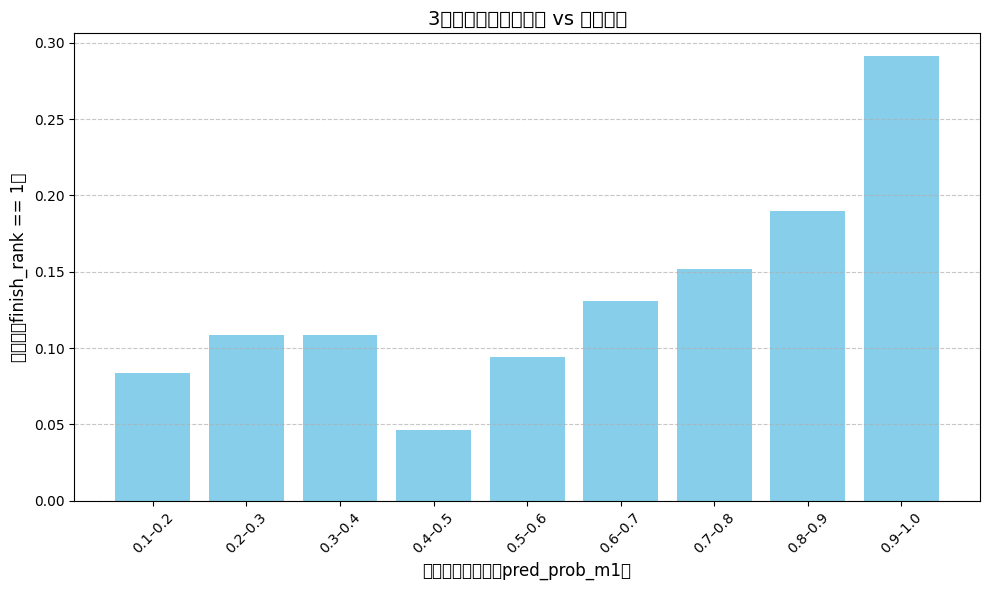

In [41]:
### Ê§úË®ºÔºöprob„ÅåÈñæÂÄ§„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„Å´Èôê„ÇäË≥ºÂÖ•„Åó„ÅüÂ†¥Âêà„ÄÅÁöÑ‰∏≠Áéá„ÇÑÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã
### Êù°‰ª∂ÔºöÂêÑ‰∫∫Ê∞ó„Åî„Å®„Å´Á¢∫Ë™ç„Åô„Çã
###   ‰æãÔºö3Áï™‰∫∫Ê∞ó„ÅÆÈ¶¨„ÅÆprob„ÅåÈ´ò„ÅÑ„Å®„Åç„Å´ÁöÑ‰∏≠Áéá„Å®ÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„Åã
### ÁµêË´ñÔºöÊîπÂñÑ„Åï„Çå„ÇãÔºÅ

# 1. 3Áï™‰∫∫Ê∞ó„ÅÆÈ¶¨„ÅÆ„ÅøÊäΩÂá∫
df_pop3 = full_pred_df[full_pred_df['popularity'] == 3].copy()

# 2. pred_prob_m1 „Çí„Éì„É≥ÂàÜ„ÅëÔºà0.0„Äú1.0„Çí0.1Âàª„Åø„Åß10Âå∫Èñì„Å´Ôºâ
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}‚Äì{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_pop3['prob_bin'] = pd.cut(df_pop3['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ÂêÑ„Éì„É≥„Åî„Å®„Å´„Çµ„É≥„Éó„É´Êï∞„ÉªÁöÑ‰∏≠Êï∞„ÉªÁöÑ‰∏≠Áéá„ÇíÈõÜË®à
bin_stats = (
    df_pop3.groupby('prob_bin')
    .agg(
        „Çµ„É≥„Éó„É´Êï∞=('finish_rank', 'count'),
        ÁöÑ‰∏≠Êï∞=('finish_rank', lambda x: (x == 1).sum())
    )
    .reset_index()
)

# ÁöÑ‰∏≠ÁéáÔºà„Éë„Éº„Çª„É≥„ÉàË°®Ë®òÔºâ„ÇíËøΩÂä†
bin_stats['ÁöÑ‰∏≠ÁéáÔºà%Ôºâ'] = (bin_stats['ÁöÑ‰∏≠Êï∞'] / bin_stats['„Çµ„É≥„Éó„É´Êï∞'] * 100).round(2)

# Ë°®„ÇíË°®Á§∫
print("‚ñº 3Áï™‰∫∫Ê∞óÈ¶¨„ÅÆ‰∫àÊ∏¨ÂãùÁéá„Å®ÂÆüÈöõ„ÅÆÁöÑ‰∏≠ÁéáÔºà„Éì„É≥ÂàÜ„ÅëÔºâ")
print(bin_stats)

# 3. ÂêÑ„Éì„É≥„Åî„Å®„ÅÆÁöÑ‰∏≠ÁéáÔºàfinish_rank == 1Ôºâ„ÇíË®àÁÆó
bin_stats = (
    df_pop3.groupby('prob_bin')
    .agg(
        count=('finish_rank', 'count'),
        hits=('finish_rank', lambda x: (x == 1).sum())
    )
)
bin_stats['hit_rate'] = bin_stats['hits'] / bin_stats['count']

# 4. „Ç∞„É©„ÉïË°®Á§∫
plt.figure(figsize=(10, 6))
plt.bar(bin_stats.index.astype(str), bin_stats['hit_rate'], color='skyblue')
plt.xlabel('‰∫àÊ∏¨ÂãùÁéá„ÅÆÁØÑÂõ≤Ôºàpred_prob_m1Ôºâ', fontsize=12)
plt.ylabel('ÁöÑ‰∏≠ÁéáÔºàfinish_rank == 1Ôºâ', fontsize=12)
plt.title('3Áï™‰∫∫Ê∞óÈ¶¨„ÅÆ‰∫àÊ∏¨ÂãùÁéá vs ÂÆüÁöÑ‰∏≠Áéá', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [27]:
### Ê§úË®ºÔºöprob„ÅåÈñæÂÄ§„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„Å´Èôê„ÇäË≥ºÂÖ•„Åó„ÅüÂ†¥Âêà„ÄÅÁöÑ‰∏≠Áéá„ÇÑÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã
### Êù°‰ª∂ÔºöÂêÑ‰∫∫Ê∞ó„Åî„Å®„Å´Á¢∫Ë™ç„Åô„Çã„ÄÇ„Åæ„Åü„ÄÅ‰∏ÄÁ∑í„Å´Ëµ∞„ÇãÈ¶¨„ÅÆprob„Åå‰Ωé„ÅÑ„Åì„Å®„ÇÇÊù°‰ª∂„Å´Âä†„Åà„Çã
###   ‰æãÔºö„Äå3Áï™‰∫∫Ê∞ó„ÅÆÈ¶¨„ÅÆprob„ÅåÈ´ò„ÅÑ„Äç„Åã„Å§„Äå1Áï™‰∫∫Ê∞ó„ÅÆprob„Åå‰Ωé„ÅÑ„Äç„Å®„Åç„Å´ÁöÑ‰∏≠Áéá„Å®ÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„Åã
### ÁµêË´ñÔºöÊîπÂñÑ„Åï„Çå„ÇãÔºÅ

# Ë®≠ÂÆöÂÄ§ÔºàÊ§úË®ºÂØæË±°„ÅÆ‰∫∫Ê∞ó„Å®ÈñæÂÄ§Ôºâ
target_popularity = 3
compared_popularity = 1
target_threshold = 0.75
compared_threshold = 0.6

# 1. ÊåáÂÆö‰∫∫Ê∞ó„ÅÆÈ¶¨„Å†„ÅëÊäΩÂá∫
target_df = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# 2. ÊØîËºÉÂØæË±°‰∫∫Ê∞óÔºà‰æãÔºö1Áï™‰∫∫Ê∞óÔºâ„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÇíÂèñÂæó
compared_probs = (
    full_pred_df[full_pred_df['popularity'] == compared_popularity]
    .loc[:, ['race_id', 'pred_prob_m1']]
    .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
)

# 3. „Éû„Éº„Ç∏
target_df = target_df.merge(compared_probs, on='race_id', how='left')

# 4. Êù°‰ª∂„Åß„Éï„Ç£„É´„Çø
filtered_df = target_df[
    (target_df['pred_prob_m1'] >= target_threshold) &
    (target_df[f'pop{compared_popularity}_prob'] <= compared_threshold)
].copy()

# 5. ÁöÑ‰∏≠Áéá„ÉªÂõûÂèéÁéá
filtered_df['hit'] = (filtered_df['finish_rank'] == 1).astype(int)
bet_count = len(filtered_df)
hit_count = filtered_df['hit'].sum()
hit_rate = hit_count / bet_count if bet_count > 0 else 0
return_sum = filtered_df.loc[filtered_df['hit'] == 1, 'odds'].sum()
roi = return_sum / bet_count if bet_count > 0 else 0

# 6. ÂãïÁöÑprintÊñáÔºà„Åì„Åì„Åå‰øÆÊ≠£ÁÆáÊâÄÔºâ
print(f"‚ñº Êù°‰ª∂Ôºö{target_popularity}Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= {target_threshold} ÔºÜ "
      f"{compared_popularity}Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= {compared_threshold}")
print(f"  Ë≥ºÂÖ•Êï∞: {bet_count}")
print(f"  ÁöÑ‰∏≠Êï∞: {hit_count}")
print(f"  ÁöÑ‰∏≠Áéá: {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"  ÂõûÂèéÁéá: {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ÂøÖË¶Å„Å™„ÇâCSVÂá∫Âäõ
filtered_df.to_csv(f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_high_pop{compared_popularity}_low.csv', index=False, encoding='cp932')


‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
  Ë≥ºÂÖ•Êï∞: 38
  ÁöÑ‰∏≠Êï∞: 12
  ÁöÑ‰∏≠Áéá: 0.3158Ôºà31.58%Ôºâ
  ÂõûÂèéÁéá: 1.4947Ôºà149.47%Ôºâ


In [29]:
### „ÄêÂá∫Âäõ„É°„É¢„Äë
### 2023Âπ¥„ÇíÂ≠¶Áøí„Åó2024Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 42
#   ÁöÑ‰∏≠Êï∞: 13
#   ÁöÑ‰∏≠Áéá: 0.3095Ôºà30.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4762Ôºà147.62%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 76
#   ÁöÑ‰∏≠Êï∞: 22
#   ÁöÑ‰∏≠Áéá: 0.2895Ôºà28.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4132Ôºà141.32%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 37
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.3784Ôºà37.84%Ôºâ
#   ÂõûÂèéÁéá: 1.7027Ôºà170.27%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.55
#   Ë≥ºÂÖ•Êï∞: 20
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1500Ôºà15.00%Ôºâ
#   ÂõûÂèéÁéá: 1.3150Ôºà131.50%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö5Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.65 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 4
#   ÁöÑ‰∏≠Áéá: 0.1739Ôºà17.39%Ôºâ
#   ÂõûÂèéÁéá: 1.9478Ôºà194.78%Ôºâ
### 2022Âπ¥„ÇíÂ≠¶Áøí„Åó2023Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 21
#   ÁöÑ‰∏≠Êï∞: 5
#   ÁöÑ‰∏≠Áéá: 0.2381Ôºà23.81%Ôºâ
#   ÂõûÂèéÁéá: 1.2429Ôºà124.29%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1304Ôºà13.04%Ôºâ
#   ÂõûÂèéÁéá: 1.2217Ôºà122.17%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö6Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.45 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 66
#   ÁöÑ‰∏≠Êï∞: 7
#   ÁöÑ‰∏≠Áéá: 0.1061Ôºà10.61%Ôºâ
#   ÂõûÂèéÁéá: 1.6106Ôºà161.06%Ôºâ
### 2021Âπ¥„ÇíÂ≠¶Áøí„Åó2022Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 62
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.2258Ôºà22.58%Ôºâ
#   ÂõûÂèéÁéá: 1.1194Ôºà111.94%Ôºâ






C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\2645380979.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fixed_pop.groupby('prob_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\2645380979.py:30: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\2645380979.py:30: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\2645380979.py:30: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\2645380979.py:30: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaV

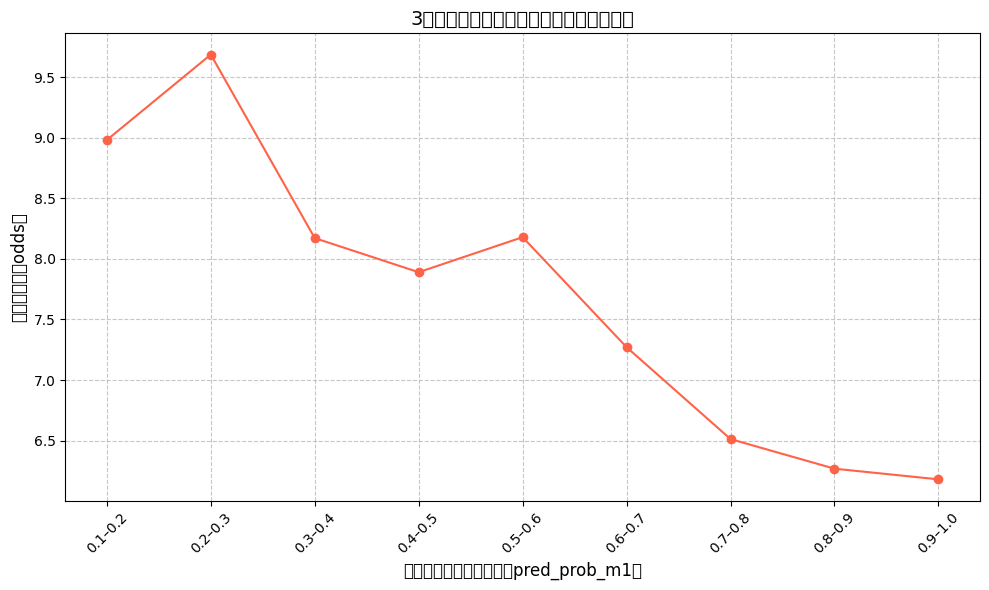

  prob_bin  „Çµ„É≥„Éó„É´Êï∞     „Ç™„ÉÉ„Ç∫Âπ≥Âùá
0  0.0‚Äì0.1      0       NaN
1  0.1‚Äì0.2     12  8.983333
2  0.2‚Äì0.3     46  9.689130
3  0.3‚Äì0.4    120  8.172500
4  0.4‚Äì0.5    152  7.890789
5  0.5‚Äì0.6    245  8.180408
6  0.6‚Äì0.7    314  7.271338
7  0.7‚Äì0.8    204  6.511765
8  0.8‚Äì0.9     58  6.267241
9  0.9‚Äì1.0     24  6.179167


In [43]:
# ‚ñº „Éë„É©„É°„Éº„ÇøÔºà‰ªªÊÑè„ÅÆ‰∫∫Ê∞ó„ÇíÊåáÂÆöÔºâ
target_popularity = 3  # 1Áï™‰∫∫Ê∞ó„ÇíÂØæË±°„Å´

# ‚ñº 1. ÊåáÂÆö‰∫∫Ê∞ó„Å†„ÅëÊäΩÂá∫
df_fixed_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº 2. „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„Åß„Éì„É≥ÂàÜ„ÅëÔºà0.0„Äú1.0 „Çí 0.1Âàª„ÅøÔºâ
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}‚Äì{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_fixed_pop['prob_bin'] = pd.cut(df_fixed_pop['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ‚ñº 3. ÂêÑ„Éì„É≥„Åî„Å®„ÅÆ„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÇíË®àÁÆó
odds_stats = (
    df_fixed_pop.groupby('prob_bin')
    .agg(
        „Çµ„É≥„Éó„É´Êï∞=('odds', 'count'),
        „Ç™„ÉÉ„Ç∫Âπ≥Âùá=('odds', 'mean')
    )
    .reset_index()
)

# ‚ñº 4. „Ç∞„É©„ÉïË°®Á§∫
plt.figure(figsize=(10, 6))
plt.plot(odds_stats['prob_bin'], odds_stats['„Ç™„ÉÉ„Ç∫Âπ≥Âùá'], marker='o', linestyle='-', color='tomato')
plt.xlabel('„É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅÆÁØÑÂõ≤Ôºàpred_prob_m1Ôºâ', fontsize=12)
plt.ylabel('„Ç™„ÉÉ„Ç∫Âπ≥ÂùáÔºàoddsÔºâ', fontsize=12)
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÈ¶¨Ôºö‰∫àÊ∏¨Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÅÆÈñ¢‰øÇ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ‚ñº Ë°®„ÅÆÂá∫ÂäõÔºàÁ¢∫Ë™çÁî®Ôºâ
print(odds_stats)

In [45]:
# ‚ñº Êù°‰ª∂Ë®≠ÂÆö
target_popularity = 5  # ‰∫∫Ê∞ó„ÇíÂõ∫ÂÆö
prob_threshold = 0.6  # ‰∫àÊ∏¨Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§
odds_filter_type = 'manual'  # 'average' or 'median' or 'manual'

# 1. ÊåáÂÆö‰∫∫Ê∞ó„ÅÆ„ÅøÊäΩÂá∫
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# 2. ‰∫àÊ∏¨Á¢∫Áéá„ÅåÈ´ò„ÅÑÈ¶¨„ÇíÊäΩÂá∫
high_prob_df = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# üîß 3. „Éï„Ç£„É´„ÇøÂæå„ÅÆ„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶„ÄÅ„Ç™„ÉÉ„Ç∫„ÅÆÂπ≥Âùá„Åæ„Åü„ÅØ‰∏≠Â§ÆÂÄ§„ÇíË®àÁÆó
if odds_filter_type == 'average':
    odds_threshold = high_prob_df['odds'].mean()
elif odds_filter_type == 'median':
    odds_threshold = high_prob_df['odds'].median()
elif odds_filter_type == 'manual':
    odds_threshold = 17.0
else:
    raise ValueError("odds_filter_type „ÅØ 'average'„ÄÅ'median'„ÄÅ'manual' „ÅÆ„ÅÑ„Åö„Çå„Åã„Å´„Åó„Å¶„Åè„Å†„Åï„ÅÑ")

# 4. „Ç™„ÉÉ„Ç∫„Åå„Åó„Åç„ÅÑÂÄ§„Çà„ÇäÈ´ò„ÅÑ/‰Ωé„ÅÑÈ¶¨„ÇíÊäΩÂá∫
filtered_df = high_prob_df[high_prob_df['odds'] < odds_threshold].copy()

# 5. ÁöÑ‰∏≠„ÉªÂõûÂèéÁéá„ÅÆË®àÁÆó
filtered_df['hit'] = (filtered_df['finish_rank'] == 1).astype(int)
bet_count = len(filtered_df)
hit_count = filtered_df['hit'].sum()
hit_rate = hit_count / bet_count if bet_count > 0 else 0
return_sum = filtered_df.loc[filtered_df['hit'] == 1, 'odds'].sum()
roi = return_sum / bet_count if bet_count > 0 else 0

# 6. ÁµêÊûúÂá∫Âäõ
print(f"‚ñº Êù°‰ª∂Ôºö{target_popularity}Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= {prob_threshold} & „Ç™„ÉÉ„Ç∫ > {odds_filter_type}({odds_threshold:.2f})")
print(f"  Ë≥ºÂÖ•Êï∞: {bet_count}")
print(f"  ÁöÑ‰∏≠Êï∞: {hit_count}")
print(f"  ÁöÑ‰∏≠Áéá: {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"  ÂõûÂèéÁéá: {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# 7. ÂøÖË¶Å„Å´Âøú„Åò„Å¶‰øùÂ≠ò
filtered_df.to_csv(
    f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_prob{prob_threshold}_oddsHigh.csv',
    index=False,
    encoding='cp932'
)


‚ñº Êù°‰ª∂Ôºö5Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.6 & „Ç™„ÉÉ„Ç∫ > manual(17.00)
  Ë≥ºÂÖ•Êï∞: 168
  ÁöÑ‰∏≠Êï∞: 18
  ÁöÑ‰∏≠Áéá: 0.1071Ôºà10.71%Ôºâ
  ÂõûÂèéÁéá: 1.3268Ôºà132.68%Ôºâ


In [47]:
# 1‰∫∫Ê∞ó„ÅÇ„Çä

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.65 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 115
#   ÁöÑ‰∏≠Êï∞: 36
#   ÁöÑ‰∏≠Áéá: 0.3130Ôºà31.30%Ôºâ
#   ÂõûÂèéÁéá: 1.2043Ôºà120.43%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.7 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 82
#   ÁöÑ‰∏≠Êï∞: 28
#   ÁöÑ‰∏≠Áéá: 0.3415Ôºà34.15%Ôºâ
#   ÂõûÂèéÁéá: 1.3085Ôºà130.85%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.75 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 52
#   ÁöÑ‰∏≠Êï∞: 19
#   ÁöÑ‰∏≠Áéá: 0.3654Ôºà36.54%Ôºâ
#   ÂõûÂèéÁéá: 1.3942Ôºà139.42%Ôºâ

# 1‰∫∫Ê∞óÊäú„Åç

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.65 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 151
#   ÁöÑ‰∏≠Êï∞: 43
#   ÁöÑ‰∏≠Áéá: 0.2848Ôºà28.48%Ôºâ
#   ÂõûÂèéÁéá: 1.0980Ôºà109.80%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.7 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 128
#   ÁöÑ‰∏≠Êï∞: 39
#   ÁöÑ‰∏≠Áéá: 0.3047Ôºà30.47%Ôºâ
#   ÂõûÂèéÁéá: 1.1773Ôºà117.73%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.75 & „Ç™„ÉÉ„Ç∫ > manual(4.50)
#   Ë≥ºÂÖ•Êï∞: 86
#   ÁöÑ‰∏≠Êï∞: 29
#   ÁöÑ‰∏≠Áéá: 0.3372Ôºà33.72%Ôºâ
#   ÂõûÂèéÁéá: 1.3047Ôºà130.47%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.7 & „Ç™„ÉÉ„Ç∫ > manual(7.00)
#   Ë≥ºÂÖ•Êï∞: 87
#   ÁöÑ‰∏≠Êï∞: 18
#   ÁöÑ‰∏≠Áéá: 0.2069Ôºà20.69%Ôºâ
#   ÂõûÂèéÁéá: 1.2023Ôºà120.23%Ôºâ

# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó & Á¢∫Áéá >= 0.7 & „Ç™„ÉÉ„Ç∫ > manual(6.50)
#   Ë≥ºÂÖ•Êï∞: 67
#   ÁöÑ‰∏≠Êï∞: 16
#   ÁöÑ‰∏≠Áéá: 0.2388Ôºà23.88%Ôºâ
#   ÂõûÂèéÁéá: 1.3627Ôºà136.27%Ôºâ

C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_22408\3836623806.py:65: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) Deja

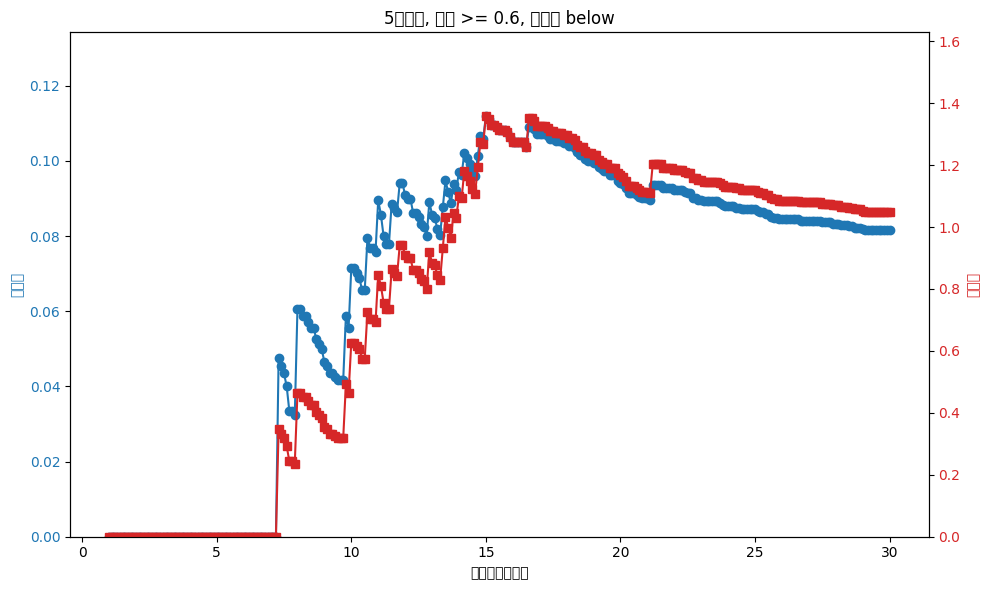

In [49]:
# ‚ñº „Éë„É©„É°„Éº„ÇøË®≠ÂÆö
target_popularity = 5
prob_threshold = 0.6
odds_min = 1.0
odds_max = 30.0
odds_step = 0.1
filter_type = 'below'  # 'below' or 'above'

# ‚ñº Ë©≤ÂΩì‰∫∫Ê∞ó„Å†„Åë„Å´Áµû„Çã
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅåÈ´ò„ÅÑÈ¶¨„ÇíÊäΩÂá∫
df_high_prob = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# ‚ñº ÁµêÊûúË®òÈå≤„É™„Çπ„Éà
odds_thresholds = []
hit_rates = []
rois = []
sample_sizes = []

# ‚ñº „Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§„ÇíÂ§âÂåñ„Åï„Åõ„Å™„Åå„ÇâÈõÜË®à
odds_range = np.arange(odds_min, odds_max + odds_step, odds_step)

for threshold in odds_range:
    if filter_type == 'below':
        subset = df_high_prob[df_high_prob['odds'] <= threshold].copy()
    elif filter_type == 'above':
        subset = df_high_prob[df_high_prob['odds'] > threshold].copy()
    else:
        raise ValueError("filter_type „ÅØ 'below' „Åæ„Åü„ÅØ 'above' „Å´„Åó„Å¶„Åè„Å†„Åï„ÅÑ")

    sample_size = len(subset)
    hit_count = (subset['finish_rank'] == 1).sum()
    return_sum = subset.loc[subset['finish_rank'] == 1, 'odds'].sum()

    hit_rate = hit_count / sample_size if sample_size > 0 else 0
    roi = return_sum / sample_size if sample_size > 0 else 0

    # ÁµêÊûúË®òÈå≤
    odds_thresholds.append(threshold)
    hit_rates.append(hit_rate)
    rois.append(roi)
    sample_sizes.append(sample_size)

# ‚ñº „Ç∞„É©„ÉïË°®Á§∫ÔºàÁöÑ‰∏≠Áéá & ÂõûÂèéÁéá„ÅÆ2Ëª∏Ôºâ
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('„Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§')
ax1.set_ylabel('ÁöÑ‰∏≠Áéá', color=color1)
ax1.plot(odds_thresholds, hit_rates, color=color1, label='ÁöÑ‰∏≠Áéá', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(hit_rates) * 1.2)

# ‚ñº ÂõûÂèéÁéá„ÅÆËª∏
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('ÂõûÂèéÁéá', color=color2)
ax2.plot(odds_thresholds, rois, color=color2, label='ÂõûÂèéÁéá', marker='s')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(rois) * 1.2)

# ‚ñº „Çø„Ç§„Éà„É´„ÉªÂá°‰æã
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞ó, Á¢∫Áéá >= {prob_threshold}, „Ç™„ÉÉ„Ç∫ {filter_type}')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [39]:

# -------- „Éë„É©„É°„Éº„Çø --------
odds_bins = np.arange(1.0, 51.0, 2.0)  # „Ç™„ÉÉ„Ç∫„Çí2Âàª„Åø„ÅßÂàÜÂâ≤
target_popularities = [2, 3]           # ÊØîËºÉ„Åó„Åü„ÅÑ‰∫∫Ê∞ó

# -------- „Éá„Éº„ÇøÂèéÈõÜ --------
plot_data = {}

for pop in target_popularities:
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    if df_pop.empty:
        continue

    df_pop['odds_bin'] = pd.cut(df_pop['odds'], bins=odds_bins, right=False)
    df_pop['hit'] = (df_pop['finish_rank'] == 1).astype(int)
    df_pop['return'] = df_pop['odds'] * df_pop['hit']

    stats = (
        df_pop.groupby('odds_bin')
        .agg(
            sample_size=('hit', 'count'),
            hit_count=('hit', 'sum'),
            return_sum=('return', 'sum')
        )
        .reset_index()
    )

    stats['hit_rate'] = stats['hit_count'] / stats['sample_size']
    stats['roi'] = stats['return_sum'] / stats['sample_size']
    stats['odds_bin_str'] = stats['odds_bin'].astype(str)
    plot_data[pop] = stats

# -------- ÂÖ±ÈÄöË®≠ÂÆö --------
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
markers = ['o', 's', 'D', '^', 'v']

# -------- „Ç∞„É©„Éï‚ë†ÔºöÁöÑ‰∏≠Áéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['hit_rate'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÁöÑ‰∏≠Áéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)])

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÁöÑ‰∏≠Áéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÁöÑ‰∏≠Áéá')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------- „Ç∞„É©„Éï‚ë°ÔºöÂõûÂèéÁéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['roi'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÂõûÂèéÁéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--')

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÂõûÂèéÁéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÂõûÂèéÁéá')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='ÂõûÂèéÁéá100%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layo

C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missin

In [205]:
# 1. ‰∫∫Ê∞ó„ÅåÈáçË§á„Åó„Å¶„ÅÑ„Çã„É¨„Éº„ÇπID„ÇíÁâπÂÆö
pop_counts = full_pred_df.groupby(['race_id', 'popularity']).size().reset_index(name='count')
duplicated_pops = pop_counts[pop_counts['count'] > 1]['race_id'].unique()

# 2. full_pred_df „Åã„ÇâÈô§Â§ñÔºàÈáçË§á‰∫∫Ê∞ó„ÇíÂê´„ÇÄ„É¨„Éº„Çπ„ÅØÂÖ®Èô§Â§ñÔºâ
clean_df = full_pred_df[~full_pred_df['race_id'].isin(duplicated_pops)].copy()

# 3. ‰∫∫Ê∞ó„Åî„Å®„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÇíÊ®™ÊåÅ„Å°„Å´„Åô„ÇãÔºàpivotÔºâ
feature_df = clean_df.copy()
feature_df['pop_col'] = feature_df['popularity'].apply(lambda x: f'pop{x}_pred_prob')
X_all = feature_df.pivot(index='race_id', columns='pop_col', values='pred_prob_m1').reset_index()

# 4. „Çø„Éº„Ç≤„ÉÉ„Éà‰∫∫Ê∞ó„ÅÆÁõÆÁöÑÂ§âÊï∞‰ΩúÊàêÔºà‰æãÔºö3Áï™‰∫∫Ê∞ó„Åå1ÁùÄ„Åã„Å©„ÅÜ„ÅãÔºâ
target_popularity = 3
y_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'finish_rank']].copy()
y_df['target'] = (y_df['finish_rank'] <= 4).astype(int)

# 5. Â≠¶ÁøíÁî®„Å´„Éû„Éº„Ç∏
data = pd.merge(X_all, y_df[['race_id', 'target']], on='race_id', how='inner')

# 6. ÁâπÂæ¥Èáè„ÉªÁõÆÁöÑÂ§âÊï∞„Å´ÂàÜÂâ≤
X = data.drop(columns=['race_id', 'target'])
y = data['target']

# 7. „É¢„Éá„É´Â≠¶ÁøíÔºà‰æãÔºöXGBoostÔºâ
from sklearn.model_selection import train_test_split
import xgboost as xgb

# race_id „ÅÆÂÖàÈ†≠2Ê°Å„Åã„Çâ„ÄåÂπ¥„Äç„ÇíÊäΩÂá∫ÔºàÊñáÂ≠óÂàó„Å®„Åó„Å¶Âá¶ÁêÜÔºâ
data['year'] = data['race_id'].astype(str).str[:2]

# Â≠¶Áøí„Éá„Éº„ÇøÔºö2023Âπ¥Ôºà= '23'Ôºâ
train_data = data[data['year'] == '23']
X_train = train_data.drop(columns=['race_id', 'target', 'year'])
y_train = train_data['target']

# Ê§úË®º„Éá„Éº„ÇøÔºö2024Âπ¥Ôºà= '24'Ôºâ
val_data = data[data['year'] == '24']
X_val = val_data.drop(columns=['race_id', 'target', 'year'])
y_val = val_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ====== „Éë„É©„É°„Éº„ÇøÂÆöÁæ© ======
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

# ====== „É¢„Éá„É´ÂÆöÁæ© ======
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 8. Ë©ï‰æ°
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)

# „É¢„Éá„É´‰∫àÊ∏¨
y_pred = model.predict(X_val)

# X_val „Å´ race_id „Çí‰ªò‰∏éÔºàÂÖÉ„ÅÆ„Éá„Éº„Çø„Åã„ÇâÂèñÂæóÔºâ
X_val_with_preds = X_val.copy()
X_val_with_preds['race_id'] = data.loc[X_val.index, 'race_id'].values
X_val_with_preds['y_true'] = y_val.values
X_val_with_preds['y_pred'] = y_pred

# race_id Âçò‰Ωç„ÅßÈáçË§á„ÇíÈô§„ÅèÔºà1‰∫∫Ê∞ó„ÅÇ„Åü„Çä1Ë°åÔºâ
target_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'odds', 'finish_rank', 'popularity']].copy()

# ‰∫àÊ∏¨ÁµêÊûú„Å®Áµ±Âêà
eval_df = pd.merge(X_val_with_preds, target_df, on='race_id', how='left')

# ‚úÖ ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞ÔºàÈáçË§áÈô§„ÅÑ„Å¶„Ç´„Ç¶„É≥„ÉàÔºâ
total_races = eval_df['race_id'].nunique()

# ‚úÖ ‰∫àÊ∏¨„Åå1Ôºà=Ë≥ºÂÖ•ÂØæË±°Ôºâ„ÅÆ„É¨„Éº„Çπ„Å†„ÅëÊäΩÂá∫
bets = eval_df[eval_df['y_pred'] == 1].copy()
bets['hit'] = (bets['finish_rank'] == 1).astype(int)  # ÁöÑ‰∏≠ = 1ÁùÄ

# Ë≥ºÂÖ•Êï∞„ÄÅÁöÑ‰∏≠Êï∞„ÄÅÊâï„ÅÑÊàª„ÅóÂêàË®à
num_bets = len(bets)
num_hits = bets['hit'].sum()
total_return = (bets['odds'] * bets['hit']).sum()
roi = total_return / num_bets if num_bets > 0 else 0
# Ë©ï‰æ°ÊåáÊ®ô
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Ê≠£Á≠îÁéá (accuracy): {acc:.4f}")
print("Ê∑∑ÂêåË°åÂàó:\n", cm)
print("ÂàÜÈ°û„É¨„Éù„Éº„Éà:\n", report)
print("\n-------------------------\n")
# ‚úÖ Âá∫Âäõ
print(f"\n‚ñº Ë©ï‰æ°ÁµêÊûúÔºà{target_popularity}Áï™‰∫∫Ê∞óÔºâ")
print(f"  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : {total_races}")
print(f"  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : {num_bets}")
print(f"  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : {num_hits}")
print(f"  Êâï„ÅÑÊàª„ÅóÂêàË®à           : {total_return:.2f}")
print(f"  ÂõûÂèéÁéá                 : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ======
prob_threshold = 0.7      # Ë≥ºÂÖ•„Åô„ÇãÁ¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö0.7Ôºâ
odds_threshold = 4.5      # Ë≥ºÂÖ•„Åô„Çã„Ç™„ÉÉ„Ç∫„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö3.0Ôºâ

# ====== ‰∫àÊ∏¨Á¢∫Áéá„ÅÆÂèñÂæó ======
y_proba = model.predict_proba(X_val)[:, 1]  # „ÇØ„É©„Çπ1Ôºà1ÁùÄ„Å´„Å™„ÇãÁ¢∫ÁéáÔºâ„ÅÆ„Åø

# ====== „Éá„Éº„ÇøÁµêÂêà ======
# X_val „Å´„ÅØ race_id „Å™„Å©„ÅÆÊÉÖÂ†±„Åå„Å™„ÅÑ„ÅÆ„Åß„ÄÅfeature_df „Åã„Çâ race_id, odds, finish_rank „ÇíÂèñÂæó
val_df_with_info = eval_df[eval_df['popularity'] == target_popularity].copy()
val_df_with_info = val_df_with_info.reset_index(drop=True)  # Âøµ„ÅÆ„Åü„ÇÅÊï¥Âàó

val_df_with_info['pred_prob'] = y_proba
val_df_with_info['hit'] = (val_df_with_info['finish_rank'] == 1).astype(int)

# ====== Ë≥ºÂÖ•„Åô„Çã„É¨„Éº„ÇπÔºàÁ¢∫Áéá„ÅåÈ´ò„ÅÑ„ÇÇ„ÅÆÔºâ ======
bets = val_df_with_info[
    (val_df_with_info['pred_prob'] >= prob_threshold) &
    (val_df_with_info['odds'] <= odds_threshold)
].copy()

# ====== ÂõûÂèéÁéá„ÉªÁöÑ‰∏≠ÁéáË®àÁÆó ======
race_count_total = len(val_df_with_info)
race_count_bet = len(bets)
hit_count = bets['hit'].sum()
hit_rate = hit_count / race_count_bet if race_count_bet > 0 else 0
total_return = bets.loc[bets['hit'] == 1, 'odds'].sum()
roi = total_return / race_count_bet if race_count_bet > 0 else 0

# ====== ÁµêÊûúË°®Á§∫ ======
print("‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ =", prob_threshold, "Ôºâ")
print(f"ÂØæË±°‰∫∫Ê∞ó           : {target_popularity}Áï™‰∫∫Ê∞ó")
print(f"ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : {race_count_total}")
print(f"Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : {race_count_bet}")
print(f"ÁöÑ‰∏≠Êï∞             : {hit_count}")
print(f"ÁöÑ‰∏≠Áéá             : {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"ÂõûÂèéÁéá             : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Ç™„Éó„Ç∑„Éß„É≥ÔºöCSVÂá∫Âäõ ======
bets.to_csv(f'pop{target_popularity}_prob{prob_threshold}_bets.csv', index=False, encoding='cp932')

import matplotlib.pyplot as plt
import xgboost as xgb

# 1. ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„ÅÆÂèñÂæóÔºàgain, weight, cover „Å™„Å©„ÅÑ„Çç„ÅÑ„Çç„ÅÇ„Çä„Åæ„Åô„Åå„ÄÅ'gain'„Åå„Çà„Åè‰Ωø„Çè„Çå„Åæ„ÅôÔºâ
importance = model.get_booster().get_score(importance_type='gain')

# 2. ËæûÊõ∏ ‚Üí DataFrame „Å´Â§âÊèõ„Åó„Å¶Ë¶ã„ÇÑ„Åô„Åè
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

# 3. Ê£í„Ç∞„É©„Éï„ÅßÂèØË¶ñÂåñ
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()  # ÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑÈ†Ü„Å´Ë°®Á§∫
plt.xlabel('Feature Importance (gain)')
plt.title('Feature Importance Plot')
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ê≠£Á≠îÁéá (accuracy): 0.6608
Ê∑∑ÂêåË°åÂàó:
 [[ 17 114]
 [ 21 246]]
ÂàÜÈ°û„É¨„Éù„Éº„Éà:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       131
           1       0.68      0.92      0.78       267

    accuracy                           0.66       398
   macro avg       0.57      0.53      0.49       398
weighted avg       0.61      0.66      0.59       398


-------------------------


‚ñº Ë©ï‰æ°ÁµêÊûúÔºà3Áï™‰∫∫Ê∞óÔºâ
  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : 398
  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : 360
  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : 48
  Êâï„ÅÑÊàª„ÅóÂêàË®à           : 271.90
  ÂõûÂèéÁéá                 : 0.7553Ôºà75.53%Ôºâ
‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ = 0.7 Ôºâ
ÂØæË±°‰∫∫Ê∞ó           : 3Áï™‰∫∫Ê∞ó
ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : 398
Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : 42
ÁöÑ‰∏≠Êï∞             : 12
ÁöÑ‰∏≠Áéá             : 0.2857Ôºà28.57%Ôºâ
ÂõûÂèéÁéá             : 1.1595Ôºà115.95%Ôºâ
          feature  importance
2  pop3_pred_prob    2.988739

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà0„Äú1Ôºâ
thresholds = np.arange(0.0, 1.01, 0.02)

roi_list = []
hit_rate_list = []
bet_count_list = []

for thr in thresholds:
    # Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫‰∏°Êñπ„ÅÆÊù°‰ª∂„ÅßË≥ºÂÖ•Âà§Êñ≠
    bets_thr = val_df_with_info[
        (val_df_with_info['pred_prob'] >= thr) &
        (val_df_with_info['odds'] <= odds_threshold)
    ].copy()
    
    num_bets = len(bets_thr)
    if num_bets > 0:
        hits = bets_thr['hit'].sum()
        hit_rate = hits / num_bets
        total_return = bets_thr.loc[bets_thr['hit'] == 1, 'odds'].sum()
        roi = total_return / num_bets
    else:
        hit_rate = 0
        roi = 0
    
    roi_list.append(roi)
    hit_rate_list.append(hit_rate)
    bet_count_list.append(num_bets)

# „Ç∞„É©„ÉïÊèèÁîª
plt.figure(figsize=(12,6))
plt.plot(thresholds, roi_list, label='ÂõûÂèéÁéá (ROI)', color='blue')
plt.plot(thresholds, hit_rate_list, label='ÁöÑ‰∏≠Áéá (Hit Rate)', color='green')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Áéá')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆÂõûÂèéÁéá„Å®ÁöÑ‰∏≠ÁéáÔºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(thresholds, bet_count_list, label='Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞', color='orange')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆË≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞Ôºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.grid(True)
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35937 (\N{CJK UNIFIED IDEOGRAPH-8C61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canva